In [1]:
import numpy as np
import json
import gzip
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import pandas as pd

# Load raw data
project_root = Path.cwd().parent
raw_data_path = project_root / "Martydepth" / "data" / "raw" / "hooktheory copy.json"

with open(raw_data_path, 'r') as f:
    raw_data = json.load(f)
    
print(f"Loaded {len(raw_data)} songs from raw data")


Loaded 26175 songs from raw data


In [2]:
def analyze_raw_song(song_data):
    """Extract key metrics from raw song data"""
    stats = {
        "num_beats": song_data.get('annotations', {}).get('num_beats', 0),
        "melody_notes": len(song_data.get('annotations', {}).get('melody', [])),
        "chord_changes": len(song_data.get('annotations', {}).get('harmony', [])),
        "melody_durations": [],
        "chord_durations": [],
        "melody_gaps": [],  # Time between melody notes
        "chord_gaps": [],   # Time between chord changes
        "unique_pitches": set(),
        "unique_chords": set(),
    }
    
    # Analyze melody
    melody = song_data.get('annotations', {}).get('melody', [])
    for i, note in enumerate(melody):
        duration = note['offset'] - note['onset']
        stats["melody_durations"].append(duration)
        stats["unique_pitches"].add((note['octave'], note['pitch_class']))
        
        if i > 0:
            gap = note['onset'] - melody[i-1]['offset']
            stats["melody_gaps"].append(gap)
    
    # Analyze harmony
    harmony = song_data.get('annotations', {}).get('harmony', [])
    for i, chord in enumerate(harmony):
        duration = chord['offset'] - chord['onset']
        stats["chord_durations"].append(duration)
        chord_key = (
            chord.get('root_pitch_class', -1),
            tuple(sorted(chord.get('root_position_intervals', []))),
            chord.get('inversion', 0)
        )
        stats["unique_chords"].add(chord_key)
        
        if i > 0:
            gap = chord['onset'] - harmony[i-1]['offset']
            stats["chord_gaps"].append(gap)
    
    return stats

# Analyze all songs
all_stats = []
for song_id, song_data in raw_data.items():
    if not isinstance(song_data, dict) or 'annotations' not in song_data:
        continue
    if 'MELODY' not in song_data.get('tags', []) or 'HARMONY' not in song_data.get('tags', []):
        continue
    
    stats = analyze_raw_song(song_data)
    if stats["num_beats"] > 0:  # Only include songs with actual content
        all_stats.append(stats)

print(f"Analyzed {len(all_stats)} valid songs")


Analyzed 23612 valid songs


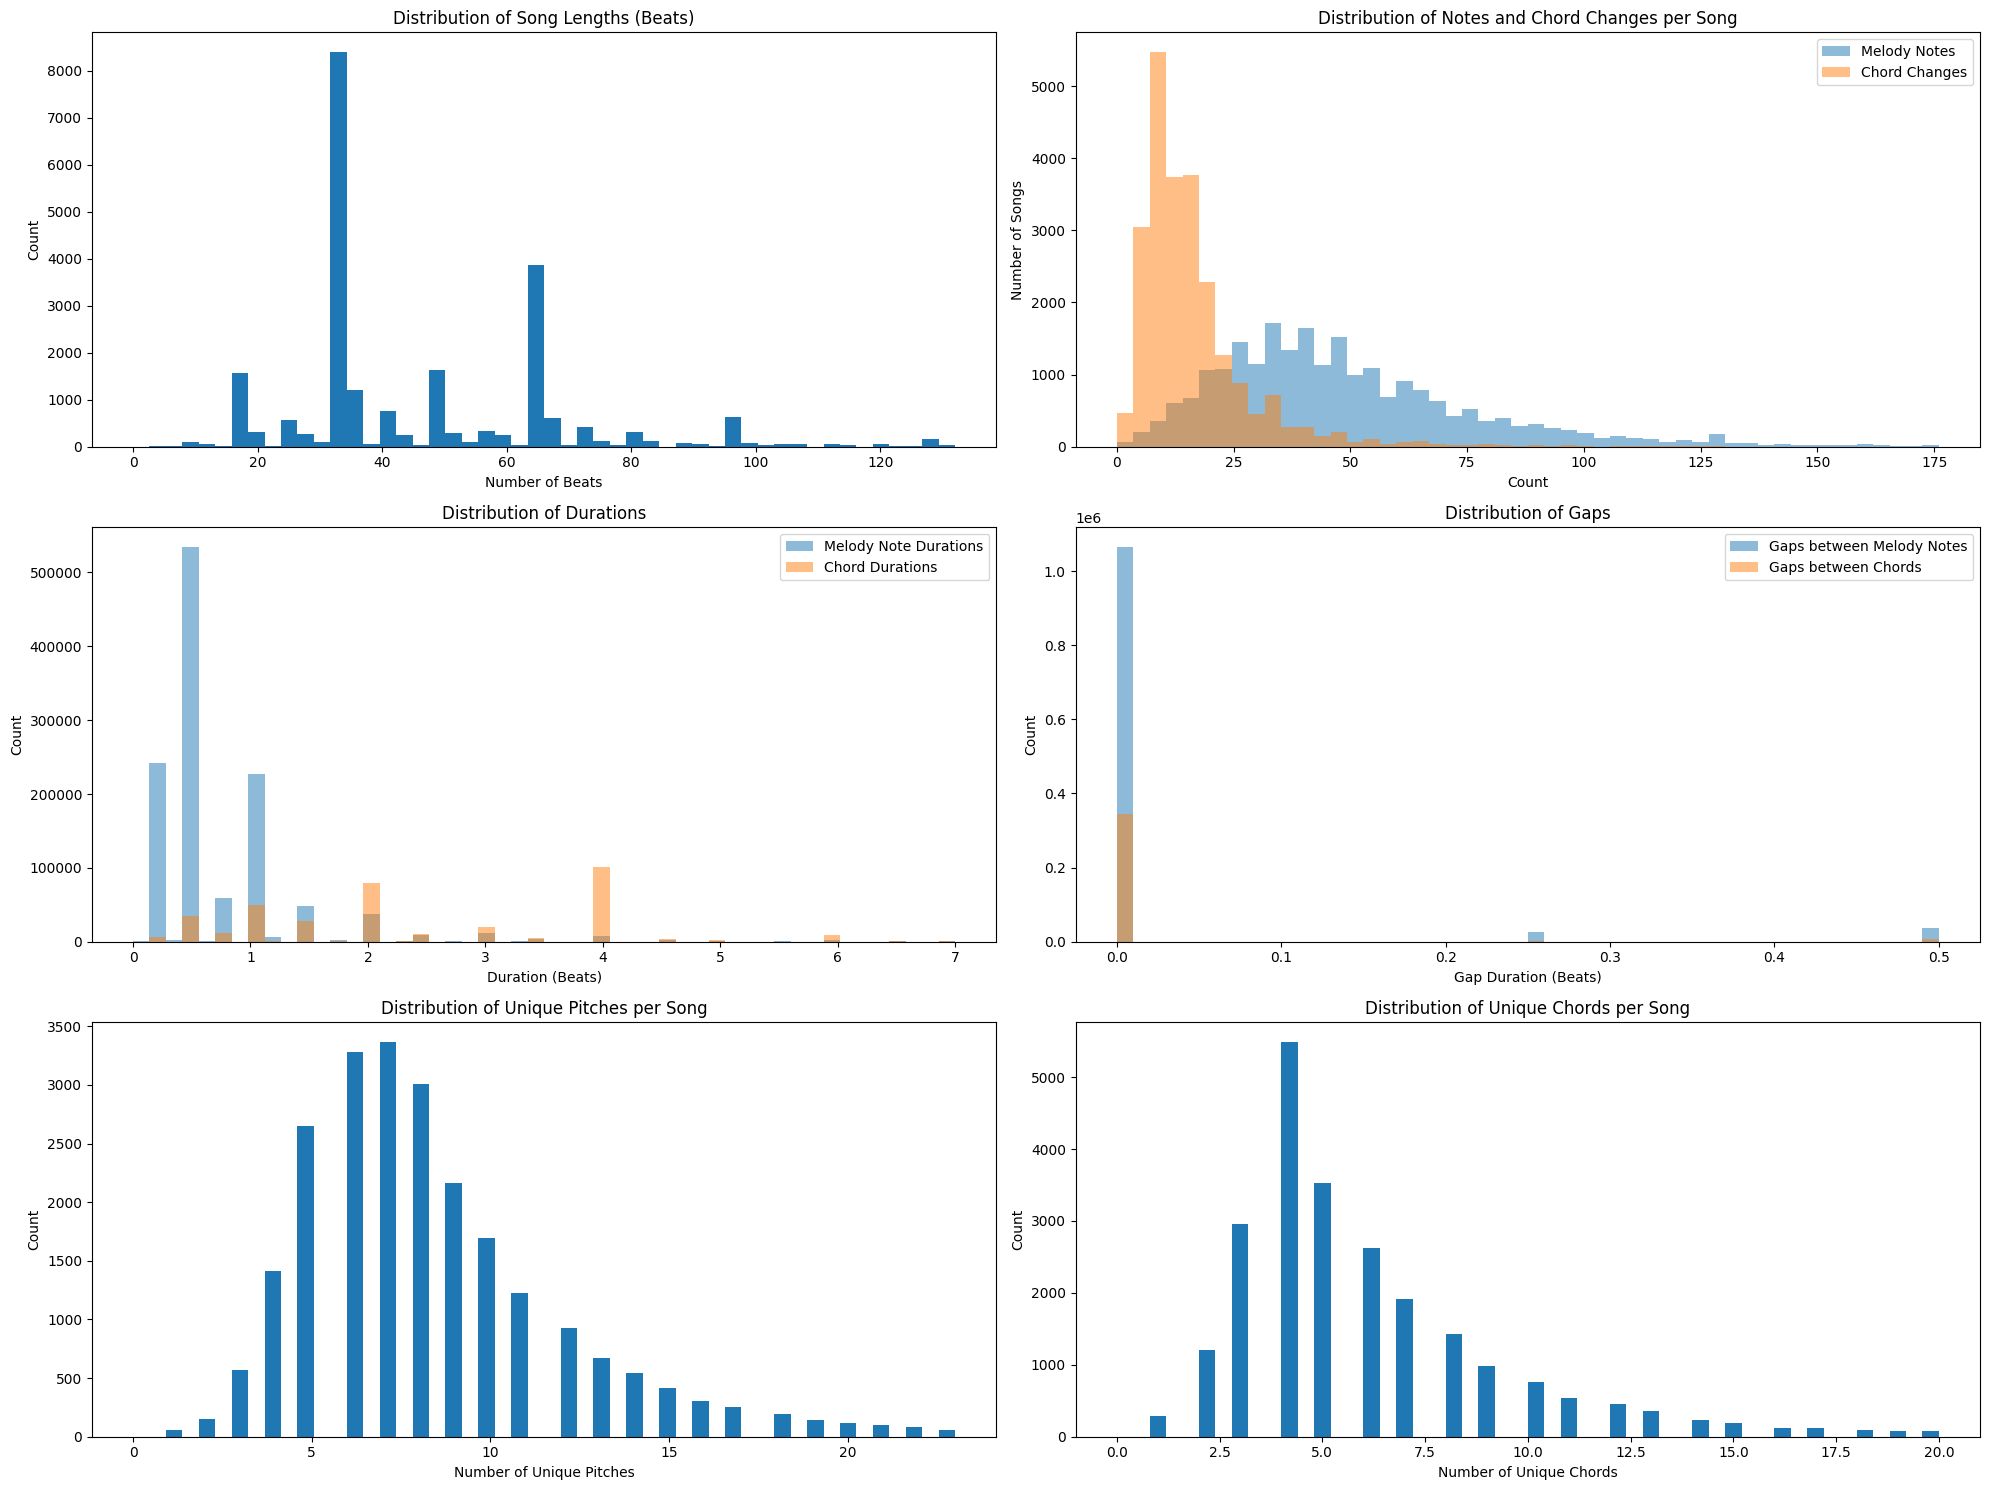


Summary Statistics:
Average song length: 47.15 beats
Average melody notes per song: 51.00
Average chord changes per song: 16.38
Average melody note duration: 0.77 beats
Average chord duration: 2.76 beats
Average gap between melody notes: 0.11 beats
Average gap between chords: 0.06 beats

Total unique pitches across dataset: 88
Total unique chords across dataset: 1519


In [4]:
# Plot raw data distributions
plt.figure(figsize=(20, 15))

# Calculate percentiles for better axis limits
song_lengths = [stats["num_beats"] for stats in all_stats]
melody_notes = [stats["melody_notes"] for stats in all_stats]
chord_changes = [stats["chord_changes"] for stats in all_stats]
unique_pitches = [len(stats["unique_pitches"]) for stats in all_stats]
unique_chords = [len(stats["unique_chords"]) for stats in all_stats]

# Song lengths - limit to 99th percentile
plt.subplot(3, 2, 1)
max_beats = np.percentile(song_lengths, 99)
plt.hist(song_lengths, bins=50, range=(0, max_beats))
plt.title("Distribution of Song Lengths (Beats)")
plt.xlabel("Number of Beats")
plt.ylabel("Count")

# Note/Chord counts - limit to 99th percentile
plt.subplot(3, 2, 2)
max_notes = np.percentile(melody_notes, 99)
max_chords = np.percentile(chord_changes, 99)
max_count = max(max_notes, max_chords)
plt.hist(melody_notes, alpha=0.5, label="Melody Notes", bins=50, range=(0, max_count))
plt.hist(chord_changes, alpha=0.5, label="Chord Changes", bins=50, range=(0, max_count))
plt.title("Distribution of Notes and Chord Changes per Song")
plt.xlabel("Count")
plt.ylabel("Number of Songs")
plt.legend()

# Duration distributions - limit to 95th percentile
plt.subplot(3, 2, 3)
all_melody_durations = [d for stats in all_stats for d in stats["melody_durations"]]
all_chord_durations = [d for stats in all_stats for d in stats["chord_durations"]]
max_duration = max(np.percentile(all_melody_durations, 95), np.percentile(all_chord_durations, 95))
plt.hist(all_melody_durations, alpha=0.5, label="Melody Note Durations", bins=50, range=(0, max_duration))
plt.hist(all_chord_durations, alpha=0.5, label="Chord Durations", bins=50, range=(0, max_duration))
plt.title("Distribution of Durations")
plt.xlabel("Duration (Beats)")
plt.ylabel("Count")
plt.legend()

# Gap distributions - limit to 95th percentile since gaps can have outliers
plt.subplot(3, 2, 4)
all_melody_gaps = [g for stats in all_stats for g in stats["melody_gaps"]]
all_chord_gaps = [g for stats in all_stats for g in stats["chord_gaps"]]
max_gap = max(np.percentile(all_melody_gaps, 95), np.percentile(all_chord_gaps, 95))
plt.hist(all_melody_gaps, alpha=0.5, label="Gaps between Melody Notes", bins=50, range=(0, max_gap))
plt.hist(all_chord_gaps, alpha=0.5, label="Gaps between Chords", bins=50, range=(0, max_gap))
plt.title("Distribution of Gaps")
plt.xlabel("Gap Duration (Beats)")
plt.ylabel("Count")
plt.legend()

# Unique elements - limit to 99th percentile
plt.subplot(3, 2, 5)
max_unique_pitches = np.percentile(unique_pitches, 99)
plt.hist(unique_pitches, bins=50, range=(0, max_unique_pitches))
plt.title("Distribution of Unique Pitches per Song")
plt.xlabel("Number of Unique Pitches")
plt.ylabel("Count")

plt.subplot(3, 2, 6)
max_unique_chords = np.percentile(unique_chords, 99)
plt.hist(unique_chords, bins=50, range=(0, max_unique_chords))
plt.title("Distribution of Unique Chords per Song")
plt.xlabel("Number of Unique Chords")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(f"Average song length: {np.mean([stats['num_beats'] for stats in all_stats]):.2f} beats")
print(f"Average melody notes per song: {np.mean([stats['melody_notes'] for stats in all_stats]):.2f}")
print(f"Average chord changes per song: {np.mean([stats['chord_changes'] for stats in all_stats]):.2f}")
print(f"Average melody note duration: {np.mean(all_melody_durations):.2f} beats")
print(f"Average chord duration: {np.mean(all_chord_durations):.2f} beats")
print(f"Average gap between melody notes: {np.mean(all_melody_gaps):.2f} beats")
print(f"Average gap between chords: {np.mean(all_chord_gaps):.2f} beats")

# Count total unique elements
all_pitches = set()
all_chords = set()
for stats in all_stats:
    all_pitches.update(stats["unique_pitches"])
    all_chords.update(stats["unique_chords"])
print(f"\nTotal unique pitches across dataset: {len(all_pitches)}")
print(f"Total unique chords across dataset: {len(all_chords)}")
